In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import ast

font_size = 6
markersize = 5
legend_marker_size = 3
mm = 1/25.4  # mm in inches
linewidth = 0.5
plt.rcParams['font.size'] = font_size
plt.rcParams['axes.linewidth'] = linewidth
overall_fig_width = 86.36 # Measurements in mm for two column
color='#00a087'
marker='o'

In [8]:
"""
Synthetic results
"""
# Noiseless
q = 7
n = 20
removal = 'uniform'
S = 1000
snr = 100

folder = f'synt_results/'
df = pd.read_csv(folder + f'q{q}_n{n}_results_S{S}_snr{snr}.csv')
df = df[df['Removal'] == removal]
df['Samples'] = df['Samples'].apply(ast.literal_eval)
df['NMSE'] = df['NMSE'].apply(ast.literal_eval)
df['b'] = df['b'].apply(ast.literal_eval)

plot_data = {
    'Samples': [s for sample_list in df['Samples'] for s in sample_list],
    'NMSE': [n for nmse_list in df['NMSE'] for n in nmse_list],
    'Delta': [d for d, sample_list in zip(df['Delta'], df['Samples']) for _ in sample_list],
    'b': [b_val for b_list in df['b'] for b_val in b_list],
    'N': [d for d, sample_list in zip(df['N'], df['Samples']) for _ in sample_list]
}

plot_df_noiseless = pd.DataFrame(plot_data)
plot_df_noiseless.head()


# Noisy
snr = 10
df = pd.read_csv(folder + f'q{q}_n{n}_results_S{S}_snr{snr}_nso.csv')
df = df[df['Removal'] == removal]
df['Samples'] = df['Samples'].apply(ast.literal_eval)
df['NMSE'] = df['NMSE'].apply(ast.literal_eval)
df['b'] = df['b'].apply(ast.literal_eval)

plot_data = {
    'Samples': [s for sample_list in df['Samples'] for s in sample_list],
    'NMSE': [n for nmse_list in df['NMSE'] for n in nmse_list],
    'Delta': [d for d, sample_list in zip(df['Delta'], df['Samples']) for _ in sample_list],
    'b': [b_val for b_list in df['b'] for b_val in b_list],
    'N': [d for d, sample_list in zip(df['N'], df['Samples']) for _ in sample_list]
}

plot_df_noisy = pd.DataFrame(plot_data)
plot_df_noisy.head()


,Samples,NMSE,Delta,b,N
0,52920,1.0,0,1,79792266297612001
1,55860,1.0,0,1,79792266297612001
2,58800,1.0,0,1,79792266297612001
3,185220,1.0,0,2,79792266297612001
4,195510,1.0,0,2,79792266297612001


In [9]:
delta_colors = {0: '#FFC61E', 40: '#00CD6C', 50: '#009ADE', 60: '#AF588A'}
removals = {0: r'q-SFT ($q=7$, $n=20$)', 40: r'GFast ($7 \times 4^2 \times 5^{{17}}$)', 50: r'GFast ($7 \times 4^{{12}} \times 5^{{7}}$)', 60: r'GFast ($7 \times 3^{{3}} \times 5^{{16}}$)'}
NR_removals = {0: r'q-SFT ($q=7$, $n=20$)', 40: r'NR-GFast ($7 \times 4^2 \times 5^{{17}}$)', 50: r'NR-GFast ($7 \times 4^{{12}} \times 5^{{7}}$)', 60: r'NR-GFast ($7 \times 3^{{3}} \times 5^{{16}}$)'}
sorted_deltas = [40, 50, 60, 0]

def plot_deltas_vs_nmse_samples(ax, plot_df, markersize=5, legend_marker_size=3, linewidth=0.5, font_size=6, legend_loc='upper right', xlabel='Sample complexity', ylabel='NMSE', noisy=False):
    """
    Plots the NMSE vs. sample complexity for different delta values, grouped by 'b'.

    Parameters:
        ax (matplotlib.axes.Axes): The axes object to plot on.
        plot_df (pd.DataFrame): The dataframe containing the data to plot.
        markersize (int, optional): Size of markers. Defaults to 5.
        legend_marker_size (int, optional): Size of legend markers. Defaults to 3.
        linewidth (float, optional): Width of plotted lines. Defaults to 0.5.
        font_size (int, optional): Font size for labels and text. Defaults to 6.
        legend_loc (str, optional): Location of legend. Defaults to 'upper right'.
    """
    for delta, color in delta_colors.items():
        subset = plot_df[plot_df['Delta'] == delta]
        subset['NMSE'] = subset['NMSE'].clip(upper=1)  # Cap NMSE values at 1
        
        # Group by 'b' and compute mean and standard deviation for both 'Samples' and 'NMSE'
        grouped = subset.groupby('b').agg(
            Samples_mean=('Samples', 'mean'),
            Samples_std=('Samples', 'std'),
            NMSE_mean=('NMSE', 'mean'),
            NMSE_std=('NMSE', 'std')
        ).reset_index()

        # Plot error bars
        ax.errorbar(
            grouped['Samples_mean'], 
            grouped['NMSE_mean'], 
            xerr=grouped['Samples_std'], 
            yerr=grouped['NMSE_std'], 
            fmt='.', 
            color=color, 
            capsize=1,
            linewidth=linewidth,
            label=f'{delta} alphabets removed',
            markersize=markersize
        )
        # Connect mean points with a line
        ax.plot(
            grouped['Samples_mean'], 
            grouped['NMSE_mean'], 
            linestyle='-', 
            color=color,
            linewidth=linewidth
        )

    labels = []
    for delta in sorted(plot_df['Delta'].unique()):
        if noisy:
            labels.append(rf'{NR_removals.get(delta)}')
        else:
            labels.append(rf'{removals.get(delta)}')

    # labels = list(delta_colors.keys())
    # handles = [
    #     plt.Line2D(
    #         [0], [0],
    #         marker='o',
    #         color='w',
    #         markerfacecolor=delta_colors.get(delta),
    #         markersize=legend_marker_size
    #     )
    #     for label in labels
    # ]
    handles = [
        plt.Line2D(
            [0], [0],
            marker='o',
            color='w',
            markerfacecolor=delta_colors.get(delta),
            markersize=legend_marker_size
        )
        for delta in sorted_deltas
    ]
    labels = [
        NR_removals.get(delta) if noisy else removals.get(delta)
        for delta in sorted_deltas
    ]
    legend_plt = ax.legend(
        handles, 
        labels, 
        loc=legend_loc, 
        framealpha=1, 
        ncol=1, 
        handletextpad=0.1, 
        columnspacing=0.5, 
        fontsize=font_size
    )
    legend_plt.get_frame().set_linewidth(linewidth)

    ax.set_xlabel(xlabel, fontsize=font_size)
    ax.set_ylabel(ylabel, fontsize=font_size)
    ax.set_xscale('log')
    ax.tick_params(axis='both', labelsize=font_size, width=linewidth)
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)


def synt_analysis(df):
    # Find rows where Delta == 0
    delta_0_only = df.loc[df['Delta'] == 0, ['Samples', 'NMSE']]
    delta_0_samples = delta_0_only.loc[delta_0_only['NMSE'] < 0.05, 'Samples']

    if delta_0_samples.empty:
        print("No rows found for Delta == 0 where NMSE < 0.05.")
        return None  # Early exit if no valid rows
    else:
        # Minimum Samples for Delta == 0
        delta_0_samples_value = delta_0_samples.min()
        unique_deltas = df['Delta'].unique()

        # Calculate results for each unique Delta
        results = {}
        for delta in unique_deltas:
            if delta == 0:
                continue  # Skip Delta == 0
            
            # Find rows where Delta == current value and NMSE < 0.05
            delta_filtered = df.loc[(df['Delta'] == delta) & (df['NMSE'] < 0.05)]
            if not delta_filtered.empty:
                # Minimum Samples for the current Delta
                min_samples_row = delta_filtered.loc[delta_filtered['Samples'].idxmin()]
                min_samples_value = min_samples_row['Samples']

                # Find the closest Samples value from Delta == 0
                closest_row = delta_0_only.iloc[(delta_0_only['Samples'] - min_samples_value).abs().idxmin()]
                
                # Compute NMSE difference
                nmse_difference = closest_row['NMSE'] - min_samples_row['NMSE']

                # Sample ratio
                ratio = min_samples_value / delta_0_samples_value

                # Store results
                results[delta] = {
                    'Samples for GFast to converge': min_samples_value,
                    'Samples for q-SFT to converge': closest_row['Samples'],
                    'NMSE difference': nmse_difference,
                    'Sample ratio': ratio
                }

        return results


/tmp/ipykernel_1055095/2440384173.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['NMSE'] = subset['NMSE'].clip(upper=1)  # Cap NMSE values at 1
/tmp/ipykernel_1055095/2440384173.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['NMSE'] = subset['NMSE'].clip(upper=1)  # Cap NMSE values at 1
/tmp/ipykernel_1055095/2440384173.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

----------------------------------------
Noiseless
----------------------------------------
Delta = 40
  Samples for GFast to converge: 262500.0
  Samples for q-SFT to converge: 252105.0
  NMSE difference: 8.79000e-01
  Sample ratio: 0.1859
Delta = 50
  Samples for GFast to converge: 146832.0
  Samples for q-SFT to converge: 43218.0
  NMSE difference: 1.00000e+00
  Sample ratio: 0.1040
Delta = 60
  Samples for GFast to converge: 81984.0
  Samples for q-SFT to converge: 43218.0
  NMSE difference: 1.00000e+00
  Sample ratio: 0.0581
Average NMSE difference: 9.59667e-01 +/- 5.70399e-02
----------------------------------------
Noisy
----------------------------------------
Delta = 40
  Samples for GFast to converge: 4602150.0
  Samples for q-SFT to converge: 4537890.0
  NMSE difference: 8.78958e-01
  Sample ratio: 0.1811
Delta = 50
  Samples for GFast to converge: 2850498.0
  Samples for q-SFT to converge: 4537890.0
  NMSE difference: 8.78952e-01
  Sample ratio: 0.1122
Delta = 60
  Samples 

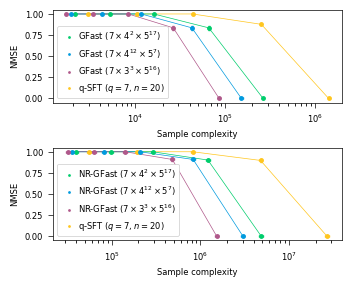

In [6]:
"""
Synthetic results
"""

fig = plt.figure(figsize=(overall_fig_width*mm, 70*mm), constrained_layout=True) 
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], width_ratios=[1], figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
plot_deltas_vs_nmse_samples(ax1, plot_df_noiseless, markersize=markersize, legend_marker_size=legend_marker_size, linewidth=linewidth, font_size=font_size, legend_loc='lower left', xlabel='Sample complexity', ylabel='NMSE')

# Noiseless analysis
results = synt_analysis(plot_df_noiseless)
print("-" * 40)
print('Noiseless')
print("-" * 40)
nmse_difference = []
for delta, metrics in results.items():
    print(f"Delta = {delta}")
    print(f"  Samples for GFast to converge: {metrics['Samples for GFast to converge']}")
    print(f"  Samples for q-SFT to converge: {metrics['Samples for q-SFT to converge']}")
    print(f"  NMSE difference: {metrics['NMSE difference']:.5e}")
    print(f"  Sample ratio: {metrics['Sample ratio']:.4f}")
    nmse_difference.append(metrics['NMSE difference'])
print(f"Average NMSE difference: {np.mean(nmse_difference):.5e} +/- {np.std(nmse_difference):.5e}")
print("-" * 40)

ax2 = fig.add_subplot(gs[1, 0])
plot_deltas_vs_nmse_samples(ax2, plot_df_noisy, markersize=markersize, legend_marker_size=legend_marker_size, linewidth=linewidth, font_size=font_size, legend_loc='lower left', xlabel='Sample complexity', ylabel='NMSE', noisy=True)

# Noisy analysis
results = synt_analysis(plot_df_noisy)
print('Noisy')
print("-" * 40)
nmse_difference = []
for delta, metrics in results.items():
    print(f"Delta = {delta}")
    print(f"  Samples for GFast to converge: {metrics['Samples for GFast to converge']}")
    print(f"  Samples for q-SFT to converge: {metrics['Samples for q-SFT to converge']}")
    print(f"  NMSE difference: {metrics['NMSE difference']:.5e}")
    print(f"  Sample ratio: {metrics['Sample ratio']:.4f}")
    nmse_difference.append(metrics['NMSE difference'])
print(f"Average NMSE difference: {np.mean(nmse_difference):.5e} +/- {np.std(nmse_difference):.5e}")
print("-" * 40)

plt.savefig('synt_figures.pdf', transparent=True, dpi=300)
plt.show()

In [10]:
"""
GFP results
"""
q = 20
n = 12
method = 'nso'
threshold = 0.01

folder = f'gfp_results/'
df = pd.read_csv(folder + f'q{q}_n{n}_{method}_{threshold}.csv')
df.head()

,Unnamed: 0,Method,Samples,b,d,nmse
0,0,q-SFT,3120,1,1,1.000000
1,1,q-SFT,6000,1,2,0.711150
2,2,q-SFT,8880,1,3,0.601674
3,3,q-SFT,11760,1,4,0.730669
4,4,q-SFT,14640,1,5,0.790530


In [11]:
# GFP
fig = plt.figure(figsize=(overall_fig_width*mm, 70*mm), constrained_layout=True) 
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], width_ratios=[1], figure=fig)

qsft = '#FFC61E'
GFast = '#00CD6C'
banned_indices_n = np.load(f'gfp_results/q{q}_n{n}_nso/banned_indices_n.pkl', allow_pickle=True)
lengths = [len(v) for v in banned_indices_n.values()]
remaining = [20 - l for l in lengths]
keys = list(banned_indices_n.keys())

ax1 = fig.add_subplot(gs[0, 0])
ax1.bar(keys, remaining, label='NR-GFast', color=GFast, edgecolor='black', linewidth=linewidth)
ax1.axhline(20, color=qsft, linewidth=linewidth, label='q-SFT')
ax1.set_yticks([4, 8, 12, 16, 20])

ax1.set_xlabel("Position", fontsize=font_size)
ax1.set_ylabel("Predictive amino acids", fontsize=font_size)
handles, labels = ax1.get_legend_handles_labels()
ordered_handles = [handles[1], handles[0]]  # Specify the desired order
ordered_labels = [labels[1], labels[0]]     # Corresponding labels
legend_plt = ax1.legend(ordered_handles, ordered_labels, fontsize=font_size, loc='upper right')
legend_plt.get_frame().set_linewidth(linewidth)
ax1.tick_params(axis='both', labelsize=font_size, width=linewidth)
# ax3.spines['top'].set_visible(False)
# ax3.spines['right'].set_visible(False)



ax2 = fig.add_subplot(gs[1, 0])
df = df[df['d'] > 5]
subset = df[df['Method'] == "q-SGFT"]
ax2.scatter(
    subset['Samples'], 
    subset['nmse'], 
    marker='.', 
    color=GFast, 
    label=f'NR-GFast', 
    s=markersize
)

subset = df[df['Method'] == "q-SFT"]
ax2.scatter(
    subset['Samples'], 
    subset['nmse'], 
    marker='.', 
    color=qsft, 
    label=f'q-SFT', 
    s=markersize
)

ax2.set_xlabel('Sample complexity', fontsize=font_size)
ax2.set_ylabel('NMSE', fontsize=font_size)
ax2.set_xscale('log')
ax2.tick_params(axis='both', labelsize=font_size, width=linewidth)
legend_plt = ax2.legend(fontsize=font_size)
legend_plt.get_frame().set_linewidth(linewidth)
plt.savefig('gfp_figures_supp.pdf', transparent=True, dpi=300)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'gfp_results/q20_n12_nso/banned_indices_n.pkl'

<Figure size 340x275.591 with 0 Axes>

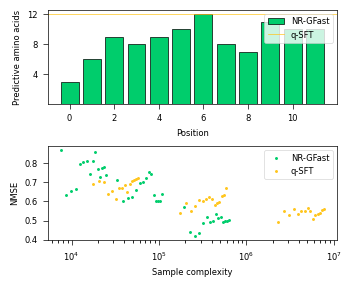

In [13]:
q = 20
n = 12
method = 'nso'
threshold = 0.05

folder = f'gfp_results/'
df = pd.read_csv(folder + f'q{q}_n{n}_{method}_{threshold}.csv')
df.head()

# GFP
fig = plt.figure(figsize=(overall_fig_width*mm, 70*mm), constrained_layout=True) 
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], width_ratios=[1], figure=fig)

qsft = '#FFC61E'
GFast = '#00CD6C'
banned_indices_n = np.load(f'gfp_results/q{q}_n{n}_nso_{threshold}/banned_indices_n.pkl', allow_pickle=True)
lengths = [len(v) for v in banned_indices_n.values()]
remaining = [20 - l for l in lengths]
keys = list(banned_indices_n.keys())

ax1 = fig.add_subplot(gs[0, 0])
ax1.bar(keys, remaining, label='NR-GFast', color=GFast, edgecolor='black', linewidth=linewidth)
ax1.axhline(max(remaining), color=qsft, linewidth=linewidth, label='q-SFT')
ax1.set_yticks([4, 8, 12])

ax1.set_xlabel("Position", fontsize=font_size)
ax1.set_ylabel("Predictive amino acids", fontsize=font_size)
handles, labels = ax1.get_legend_handles_labels()
ordered_handles = [handles[1], handles[0]]  # Specify the desired order
ordered_labels = [labels[1], labels[0]]     # Corresponding labels
legend_plt = ax1.legend(ordered_handles, ordered_labels, fontsize=font_size, loc='upper right')
legend_plt.get_frame().set_linewidth(linewidth)
ax1.tick_params(axis='both', labelsize=font_size, width=linewidth)
# ax3.spines['top'].set_visible(False)
# ax3.spines['right'].set_visible(False)



ax2 = fig.add_subplot(gs[1, 0])
df = df[df['d'] > 5]
subset = df[df['Method'] == "GFast"]
ax2.scatter(
    subset['Samples'], 
    subset['nmse'], 
    marker='.', 
    color=GFast, 
    label=f'NR-GFast', 
    s=markersize
)

subset = df[df['Method'] == "q-SFT"]
ax2.scatter(
    subset['Samples'], 
    subset['nmse'], 
    marker='.', 
    color=qsft, 
    label=f'q-SFT', 
    s=markersize
)

ax2.set_xlabel('Sample complexity', fontsize=font_size)
ax2.set_ylabel('NMSE', fontsize=font_size)
ax2.set_xscale('log')
ax2.tick_params(axis='both', labelsize=font_size, width=linewidth)
legend_plt = ax2.legend(fontsize=font_size)
legend_plt.get_frame().set_linewidth(linewidth)
plt.savefig('gfp_figures.pdf', transparent=True, dpi=300)
plt.show()

In [14]:
filtered_df = df[(df["Samples"] >= 1e4) & (df["Samples"] <= 1e5)]

# Group by Method and compute mean and std for nmse and Samples
stats = (
    filtered_df.groupby("Method")
    .agg(
        avg_nmse=("nmse", "mean"),
        std_nmse=("nmse", "std"),
        avg_samples=("Samples", "mean"),
        std_samples=("Samples", "std"),
    )
    .reset_index()
)

# Print the results
print(stats)

  Method  avg_nmse  std_nmse  avg_samples  std_samples
0  GFast  0.717268  0.075687      42808.2  28701.47045
1  q-SFT  0.681344  0.032717      37680.0  12879.75155


In [18]:
filtered_df = df[(df["Samples"] >= 1e5) & (df["Samples"] <= 1e6)]

# # For each method, select the 10 lowest NMSEs and their corresponding Samples
# lowest_nmse_df = (
#     filtered_df.sort_values(by="nmse")
#     .groupby("Method")
#     .head(10)  # Take the 10 lowest NMSEs per method
# )

# Group by Method and compute mean and std for the selected data
stats = (
    filtered_df.groupby("Method")
    .agg(
        avg_nmse=("nmse", "mean"),
        std_nmse=("nmse", "std"),
        avg_samples=("Samples", "mean"),
        std_samples=("Samples", "std"),
    )
    .reset_index()
)

# Print the results
print(stats)

  Method  avg_nmse  std_nmse    avg_samples    std_samples
0  GFast  0.509287  0.055731  380181.176471  168420.922738
1  q-SFT  0.601103  0.032895  376800.000000  128797.515504


In [16]:
filtered_df = df[(df["Samples"] >= 1e6) & (df["Samples"] <= 1e7)]

# Group by Method and compute mean and std for nmse and Samples
stats = (
    filtered_df.groupby("Method")
    .agg(
        avg_nmse=("nmse", "mean"),
        std_nmse=("nmse", "std"),
        avg_samples=("Samples", "mean"),
        std_samples=("Samples", "std"),
    )
    .reset_index()
)   

# Print the results
print(stats)

  Method  avg_nmse  std_nmse  avg_samples   std_samples
0  q-SFT  0.540482  0.020348    5024000.0  1.717300e+06
